In [1]:
import sys
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/data/clustering/analysis/')
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')

from functions import *
import shap
import xgboost
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from matplotlib import colors as plt_colors

In [2]:
group_main = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/grp/main_grads.csv').iloc[:, 1:]
group_replace = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/grp/replace_grads.csv').iloc[:, 1:]
group_suppress = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/grp/suppress_grads.csv').iloc[:, 1:]
group_clear = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/grp/clear_grads.csv').iloc[:, 1:]

group_main.columns = ['maintain_g1', 'maintain_g2', 'maintain_g3']
group_replace.columns = ['replace_g1', 'replace_g2', 'replace_g3']
group_suppress.columns = ['suppress_g1', 'suppress_g2', 'suppress_g3']
group_clear.columns = ['clear_g1', 'clear_g2', 'clear_g3']

group_grads = pd.concat([group_main, group_replace, group_suppress, group_clear], axis=1).reset_index()

In [3]:
import glob
import pandas as pd
import re

# Define the pattern to match files
pattern = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/sub*_sm_vector/sub*_sm_vector_*_all_ops.csv'

# Use glob to find all files that match the pattern
file_list = sorted(glob.glob(pattern))

# Initialize an empty list to store DataFrames
dataframes = []

for file in file_list:
    # Extract subject ID from the file path
    subject_id = re.search(r'sub(\d+)_', file).group(1)
    
    # Extract the part of the filename before '_all_ops'
    grad = re.search(r'_(g\d+)_all_ops', file).group(1)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file)
    
    # Add the subject ID as a new column
    df['SubID'] = subject_id
    
    # Add the 'grad' as a new column
    df['grad'] = grad
    
    # Append the DataFrame to the list
    dataframes.append(df)

# Combine all DataFrames into one, if necessary
combined_df = pd.concat(dataframes, ignore_index=True)

# Now 'combined_df' contains all data with a 'SubID' and 'grad' column indicating the subject ID and the gradient respectively.
# Adjusting the DataFrame by dropping and reordering columns as required
combined_df = combined_df.drop(['Unnamed: 0', 'sub'], axis=1, errors='ignore')  # errors='ignore' handles cases where these columns might not exist
combined_df = combined_df[['index', 'SubID', 'maintain', 'replace', 'suppress', 'clear', 'grad']]

# combined_df now includes the 'grad' column with the part of the filename you were interested in.

In [4]:
combined_df_g1 = combined_df.query('grad == "g1"').drop('grad', axis=1).reset_index(drop=True)
combined_df_g1.columns = ['index', 'SubID', 'maintain_g1', 'replace_g1', 'suppress_g1', 'clear_g1']

combined_df_g2 = combined_df.query('grad == "g2"').drop('grad', axis=1).reset_index(drop=True)
combined_df_g2.columns = ['index', 'SubID', 'maintain_g2', 'replace_g2', 'suppress_g2', 'clear_g2']

combined_df_g3 = combined_df.query('grad == "g3"').drop('grad', axis=1).reset_index(drop=True)
combined_df_g3.columns = ['index', 'SubID', 'maintain_g3', 'replace_g3', 'suppress_g3', 'clear_g3']

In [5]:
combined_all = pd.concat([combined_df_g1, 
                          combined_df_g2.drop(['index', 'SubID'], axis=1), 
                          combined_df_g3.drop(['index', 'SubID'], axis=1)], axis=1)

combined_all = combined_all[['index', 'SubID', 'maintain_g1', 'maintain_g2', 'maintain_g3', 'replace_g1', 'replace_g2', 'replace_g3', 
              'suppress_g1', 'suppress_g2', 'suppress_g3', 'clear_g1', 'clear_g2', 'clear_g3']]

In [6]:
def grad_cors(data, sub):
   
    global group_grads

    training = group_grads
    
    testing = data.query('SubID == @sub').drop(['SubID'], axis=1)
     
    #corr_matrix = X_training.corrwith(X_testing, method='spearman')
    corr_matrix = training.corrwith(testing, method='spearman')
    sub_means = corr_matrix.mean()
    print(sub_means)
    
    return   testing, sub_means

In [7]:
euclidean_distance = """import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def calculate_distances(df1, df2, op, sub):
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(.5,1))
    df1.iloc[:, 1:] = scaler.fit_transform(df1.iloc[:, 1:])
    df2.iloc[:, 1:] = scaler.fit_transform(df2.iloc[:, 1:])
    
    # Identify the columns in df1 that start with the op prefix
    op_columns = [col for col in df1.columns if col.startswith(op)]
    # Calculate Euclidean distances based on the identified columns
    distances = np.sqrt(sum((df1[col] - df2[col])**2 for col in op_columns))
    
    # Convert distances to a DataFrame and transpose it
    distances_df = pd.DataFrame(distances).T
    
    # Add the 'SubID' column with the value of 'sub'
    distances_df['SubID'] = sub
    
    # Rearrange columns so 'SubID' is the first column
    cols = distances_df.columns.tolist()  # Convert column names to a list
    cols = cols[-1:] + cols[:-1]  # Move the last column (SubID) to the first position
    distances_df = distances_df[cols]  # Reassign rearranged columns back to DataFrame
    
    # Generate new column names with the specified prefix and numeric indices for distance columns
    new_columns = ['SubID'] + [f'{op}_{i}' for i in range(len(distances_df.columns)-1)]
    # Assign the new column names to the DataFrame
    distances_df.columns = new_columns
    
    return distances_df
"""

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

def calculate_distances(df1, df2, op, sub):
    scaler = MinMaxScaler(feature_range=(.5,1))
    #df1.iloc[:, 1:] = scaler.fit_transform(df1.iloc[:, 1:])
    #df2.iloc[:, 1:] = scaler.fit_transform(df2.iloc[:, 1:])
    
    # Identify the columns in df1 that start with the op prefix
    op_columns = [col for col in df1.columns if col.startswith(op)]
    
    # Calculate the inverse of the covariance matrix based on df1
    cov_matrix = np.cov(df1[op_columns].T)
    inv_cov_matrix = inv(cov_matrix)
    
    # Initialize an empty list to store Mahalanobis distances
    distances = []
    
    # Calculate Mahalanobis distance for each row in df2 relative to df1
    for index, row in df2.iterrows():
        distances.append(mahalanobis(row[op_columns], df1[op_columns].mean(), inv_cov_matrix))
    
    # Convert distances to a DataFrame and transpose it
    distances_df = pd.DataFrame(distances, columns=['Distance']).T
    
    # Add the 'SubID' column with the value of 'sub'
    distances_df['SubID'] = sub
    
    # Rearrange columns so 'SubID' is the first column
    cols = distances_df.columns.tolist()  # Convert column names to a list
    cols = cols[-1:] + cols[:-1]  # Move the last column (SubID) to the first position
    distances_df = distances_df[cols]  # Reassign rearranged columns back to DataFrame
    
    # Generate new column names with the specified prefix and numeric indices for distance columns
    new_columns = ['SubID'] + [f'{op}_Mahalanobis_{i}' for i in range(len(distances_df.columns)-1)]
    # Assign the new column names to the DataFrame
    distances_df.columns = new_columns
    
    return distances_df


In [9]:
# Example usage
# Assuming df1 and df2 have been defined and op is the prefix like 'maintain'
# Example: df1 and df2 should have columns like 'maintain_g1', 'maintain_g2', 'maintain_g3' etc.
distances_list=[]
for i in combined_all.SubID.unique():
    for j in ['maintain', 'replace', 'suppress', 'clear']:
        sub_grads = combined_all.query('SubID == @i').drop(['SubID'], axis=1).reset_index(drop=True)
        distances_list.append(calculate_distances(group_grads, sub_grads, j, i))
    
distance_df = pd.concat(distances_list)
# Define a custom aggregation function that ignores NAs
# This function takes the first non-NA value it finds across the rows
def first_non_na(series):
    return series.dropna().iloc[0] if not series.dropna().empty else np.nan

# Group by 'SubID' and apply the custom aggregation function to each column
subject_deviation = distance_df.groupby('SubID', as_index=False).agg(first_non_na)

In [10]:
def grad_cors(df1, df2, sub):

    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(.5,1))
    #df1.iloc[:, 1:] = scaler.fit_transform(df1.iloc[:, 1:])
    #df2.iloc[:, 1:] = scaler.fit_transform(df2.iloc[:, 1:])

    corr_matrix = df1.corrwith(df2)

    corr_matrix = pd.DataFrame(df1.corrwith(df2, method='spearman')).iloc[1:].T

    cols = ['SubID'] + corr_matrix.columns.to_list()

    corr_matrix['SubID'] = sub

    corr_matrix = corr_matrix[cols]
    return corr_matrix

corrs_list=[]
for i in combined_all.SubID.unique():
        sub_grads = combined_all.query('SubID == @i').drop(['SubID'], axis=1).reset_index(drop=True)
        corrs_list.append(grad_cors(group_grads, sub_grads, i)) 
        
subject_correlation = pd.concat(corrs_list).reset_index(drop=True)

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def calculate_network_distances(df1, df2, op, network, sub):
    
    if network == 1:
        net = 'vn'
    elif network == 2: 
        net = 'smn'
    elif network == 3: 
        net = 'fpcn'
    elif network == 4: 
        net = 'dmn'

    wm_networks = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/wm_networks.csv')
    wm_networks = wm_networks.reset_index()

    sub_df = df2.query('SubID == @sub')
    
    sub_grads = (pd.merge(wm_networks, sub_df, on ='index')
                 .query('Subtype == @network')
                 .drop('Subtype', axis=1)
                 .reset_index(drop=True))

    group_grads_network = (pd.merge(wm_networks, group_grads, on ='index')
                           .query('Subtype == @network')
                           .drop('Subtype', axis=1)
                           .reset_index(drop=True))

    mean_df = (pd.DataFrame(calculate_distances(group_grads_network, sub_grads, op, sub).iloc[:, 1:].T.mean(), 
                           columns=[op+'_'+net+'_mean'])
               .assign(SubID = sub)
               .iloc[:, [1,0]])

    return mean_df

network_distances_list=[]
for i in combined_all.SubID.unique():
    for j in ['maintain', 'replace', 'suppress', 'clear']:
        for k in list(range(1,5)):
            network_distances_list.append(calculate_network_distances(group_grads, combined_all, j,k, i))
    
network_distance_df = pd.concat(network_distances_list)

# Define a custom aggregation function that ignores NAs
# This function takes the first non-NA value it finds across the rows
def first_non_na(series):
    return series.dropna().iloc[0] if not series.dropna().empty else np.nan

# Group by 'SubID' and apply the custom aggregation function to each column
subject_network_deviation = network_distance_df.groupby('SubID', as_index=False).agg(first_non_na)

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def calculate_network_correlations(df1, df2, network, sub):
    
    # Network identifiers
    if network == 1:
        net = 'vn'
    elif network == 2: 
        net = 'smn'
    elif network == 3: 
        net = 'fpcn'
    elif network == 4: 
        net = 'dmn'

    # Load the network data (assuming it's the same as the one used for distance calculations)
    wm_networks = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/wm_networks.csv')
    wm_networks = wm_networks.reset_index()

    # Filter the subject-specific gradients and the group gradients based on the network type
    sub_grads = (pd.merge(wm_networks, df2, on='index')
                 .query('Subtype == @network')
                 .drop('Subtype', axis=1)
                 .reset_index(drop=True))

    group_grads_network = (pd.merge(wm_networks, df1, on='index')
                           .query('Subtype == @network')
                           .drop('Subtype', axis=1)
                           .reset_index(drop=True))

    mean_df = pd.DataFrame(grad_cors(group_grads_network, sub_grads, sub)).iloc[:, :-1]
    
    cols_vn = [col + '_'+net for col in mean_df.iloc[:, 1:].columns.to_list()]
    mean_df.columns = ['SubID'] + cols_vn

    return mean_df

In [13]:
net_corrs_list = []
for sub_id in combined_all.SubID.unique():
    for network in range(1, 5):  # Assuming 4 networks as in the distance example
        net_corrs_list.append(calculate_network_correlations(group_grads, combined_all.query('SubID == @sub_id'), network, sub_id))

subject_network_cors = pd.concat(net_corrs_list).reset_index(drop=True)

# Assuming you have a similar setup for grouping and aggregating results as in the network distance example:
# Define a custom aggregation function that ignores NAs
def first_non_na(series):
    return series.dropna().iloc[0] if not series.dropna().empty else np.nan

# Group by 'SubID' and 'Network' if needed, and apply the custom aggregation function to each column
subject_network_correlation = subject_network_cors.groupby('SubID', as_index=False).agg(first_non_na)

In [14]:
matched_subid = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/matched_subid.csv')
matched_subid.columns = ['sub', 'SubID']

In [15]:
subject_deviation.SubID = subject_deviation.SubID.astype(int)
subject_correlation.SubID = subject_correlation.SubID.astype(int)
subject_network_deviation.SubID = subject_network_deviation.SubID.astype(int)
subject_network_correlation.SubID = subject_network_correlation.SubID.astype(int)

In [16]:
subject_deviation = pd.merge(matched_subid, subject_deviation, on ='SubID').rename({'sub':'SubID', 'SubID':'sub'}, axis=1)
subject_correlation = pd.merge(matched_subid, subject_correlation, on ='SubID').rename({'sub':'SubID', 'SubID':'sub'}, axis=1)
subject_network_deviation = pd.merge(matched_subid, subject_network_deviation, on ='SubID').rename({'sub':'SubID', 'SubID':'sub'}, axis=1)
subject_network_correlation = pd.merge(matched_subid, subject_network_correlation, on ='SubID').rename({'sub':'SubID', 'SubID':'sub'}, axis=1)

In [17]:
subject_deviation.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/subject_dev_cor/subject_deviation.csv', index=False)
subject_correlation.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/subject_dev_cor/subject_correlation.csv', index=False)
subject_network_deviation.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/subject_dev_cor/subject_network_deviation.csv', index=False)
subject_network_correlation.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/subject_dev_cor/subject_network_correlation.csv', index=False)

In [18]:
def pls(data, target, networks, color, save=None):


    regex_string = '|'.join(networks)

    import seaborn as sns
    from sklearn.cross_decomposition import PLSRegression
    from scipy.stats import t
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm

    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import StandardScaler
    
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import LeaveOneOut
    # Create an instance of LeaveOneOut
    loo = LeaveOneOut()

    
    scaler=MinMaxScaler()
    
    X_data = data
    # Extract the feature matrix X and target variable y
    X = (X_data 
             .filter(regex=regex_string)
             #.filter(like='dispersion_md')
             #.filter(regex='^(?!.*(main|suppress|replace)).*$')
             #.filter(regex='^(?!.*(maintain_smn)).*$') 
            )

    # fit and transform the entire dataframe
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    y = X_data[target]
    y = pd.DataFrame(scaler.fit_transform(y), columns=y.columns)

    # Set the number of permutations and bootstrap repetitions
    n_permutations = 10000
    n_bootstrap = 10000

    pls = PLSRegression(n_components=1)
        
    # Perform leave-one-out cross-validation to determine the optimal number of components
    #mse_values = []
    #for n_components in range(1, len(X.columns)+1):
    #    pls.n_components = n_components
    #    y_pred = cross_val_predict(pls, X, y, cv=loo)
    #    mse = mean_squared_error(y, y_pred)
    #    mse_values.append(mse)

    #pls = PLSRegression(n_components=1)
    #optimal_n_components = np.argmin(mse_values) + 1
    #print('Optimal number of components:', optimal_n_components)

    # Fit the PLSRegression model to the feature matrix X and target variable y using the optimal number of components
    pls.n_components = 1 #optimal_n_components
    pls.fit(X, y)

    # Compute the singular value of the fitted model
    x_score = pls.x_scores_
    y_score = pls.y_scores_
    singular_value = np.dot(x_score.T, y_score)
    print('Starting Permutations')
    # Generate permuted data matrices by randomly reordering the rows of the original data matrix X
    permuted_singular_values = []
    for i in range(n_permutations):
        permuted_X = X.sample(frac=1, replace=False)
        pls.fit(permuted_X, y)
        x_score = pls.x_scores_
        y_score = pls.y_scores_
        permuted_singular_value = np.dot(x_score.T, y_score)
        permuted_singular_values.append(permuted_singular_value)

    # Compute the p-value of the singular value by comparing it to the null distribution of singular values
    p_value = (np.sum(permuted_singular_values >= singular_value) + 1) / (n_permutations + 1)
    
    import seaborn as sns
    from sklearn.cross_decomposition import PLSRegression
    from scipy.stats import t
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    import matplotlib

       # Prepare data for the histogram
    singular_list = [i[0][0] for i in permuted_singular_values]
    singulars = pd.DataFrame(singular_list, columns=['Singulars'])
    singular_val = singular_value[0][0]

    # Begin plotting
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # Set up a figure with two subplots
    
    # Scatter plot on the left
    sns.set_theme(style="white")

    sns.regplot(x=x_score.flatten(), y=y_score.flatten(), 
                ax=axs[0], color=color, scatter_kws={'alpha':0.6}, truncate=False)
    axs[0].set_xlabel('Network Dispersion (Latent Variable)', fontsize=14)
    axs[0].set_ylabel('Behavior (Latent Variable)', fontsize=14)
    axs[0].set_title('Network Dispersion Predicting Behavior', fontsize=14, fontweight='bold')
    
       # Displaying 'permuted P = ' with manual positioning for readability
    axs[0].text(.06, 1, 'permuted ', transform=axs[0].transAxes, fontsize=13, verticalalignment='top', color='black')
    axs[0].text(.22, 1, 'P', transform=axs[0].transAxes, fontsize=13, verticalalignment='top', color='black', fontstyle='italic')
    axs[0].text(.24, 1, ' = {:.3f}'.format(p_value), transform=axs[0].transAxes, fontsize=13, verticalalignment='top', color='black')
    
    sns.despine(ax=axs[0])

    # Histogram on the right
    sns.histplot(singulars, kde=False, ax=axs[1])
    axs[1].axvline(x=singular_val, color='r', linestyle='--', label='Singular Value')
    axs[1].legend()
    axs[1].set_title("Singular Value vs. Null Distribution", fontsize=14, fontweight='bold')
    axs[1].set_xlabel('Permuted Singular Values (Null)', fontsize=14)
    sns.despine(ax=axs[1])
    plt.tight_layout()  # Adjust layout to not overlap
    
    if save is not None:
        save_path = f"/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/pls_plots/{save}.png"
        plt.savefig(save_path, dpi=700)
        
    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()
    

    return p_value, x_score, y_score, permuted_singular_values, singular_value


In [19]:
z_data = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/ClearMem_Z_Average.csv')
z_data = z_data[['SubID', 'z_ave', 'PSWQ_total', 'WBSI_total', 'RRS_total', 'RRS_depression', 'RRS_brooding', 'RRS_reflection']]
z_data = z_data.dropna()

In [20]:
subject_deviation_z = pd.merge(z_data, subject_deviation, on='SubID').drop('sub', axis=1)
subject_correlation_z = pd.merge(z_data, subject_deviation, on='SubID').drop('sub', axis=1)
subject_network_deviation_z = pd.merge(z_data, subject_network_deviation, on='SubID').drop('sub', axis=1)
subject_network_correlation_z = pd.merge(z_data, subject_network_correlation, on='SubID').drop('sub', axis=1)

Starting Permutations


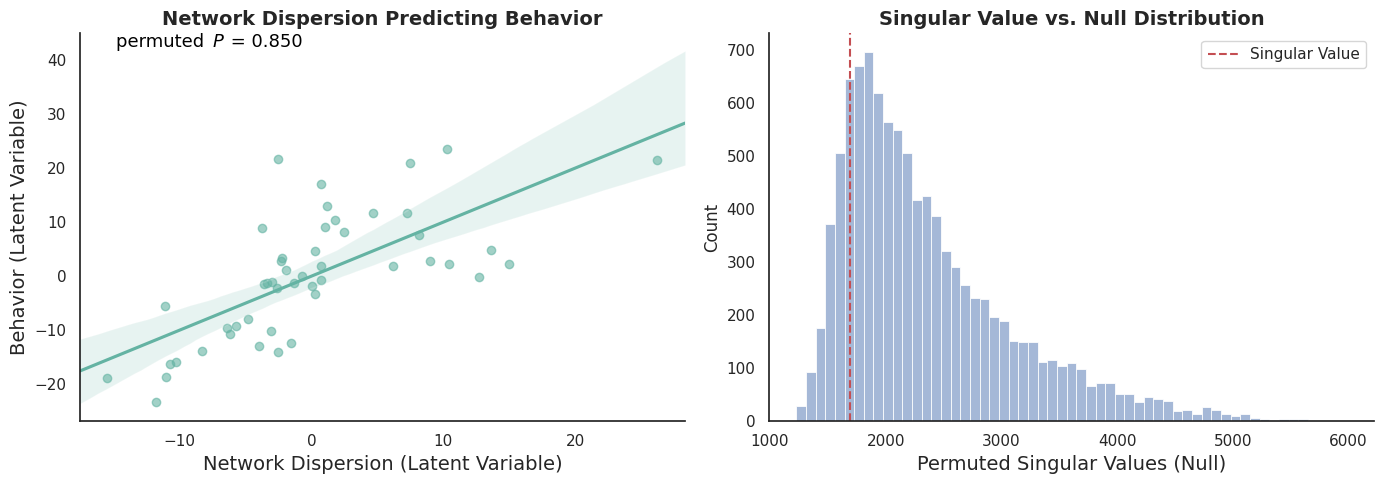

Starting Permutations


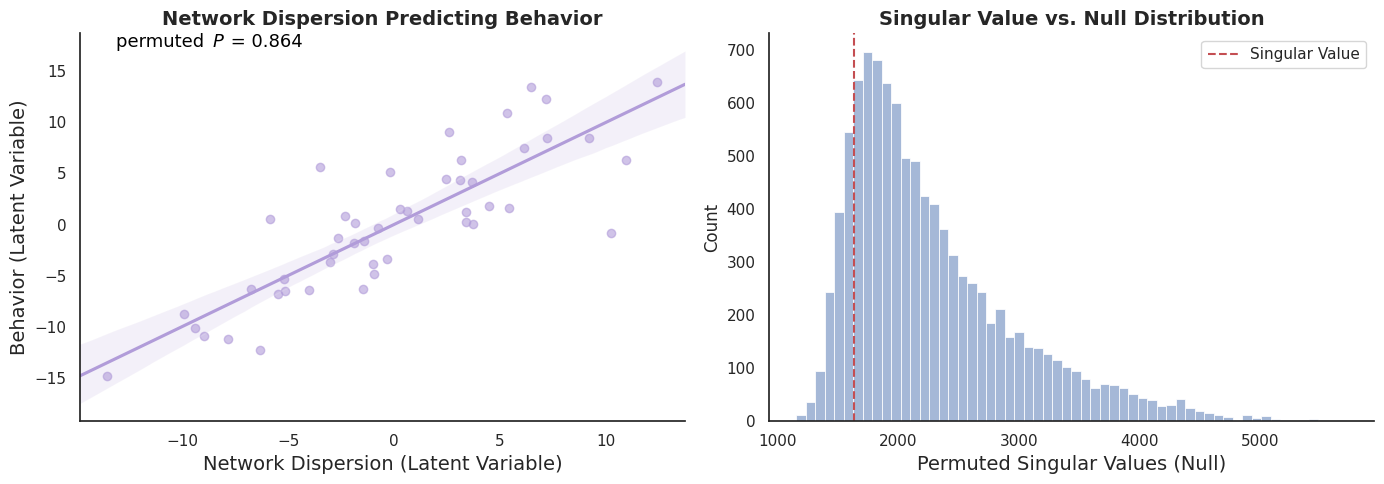

Starting Permutations


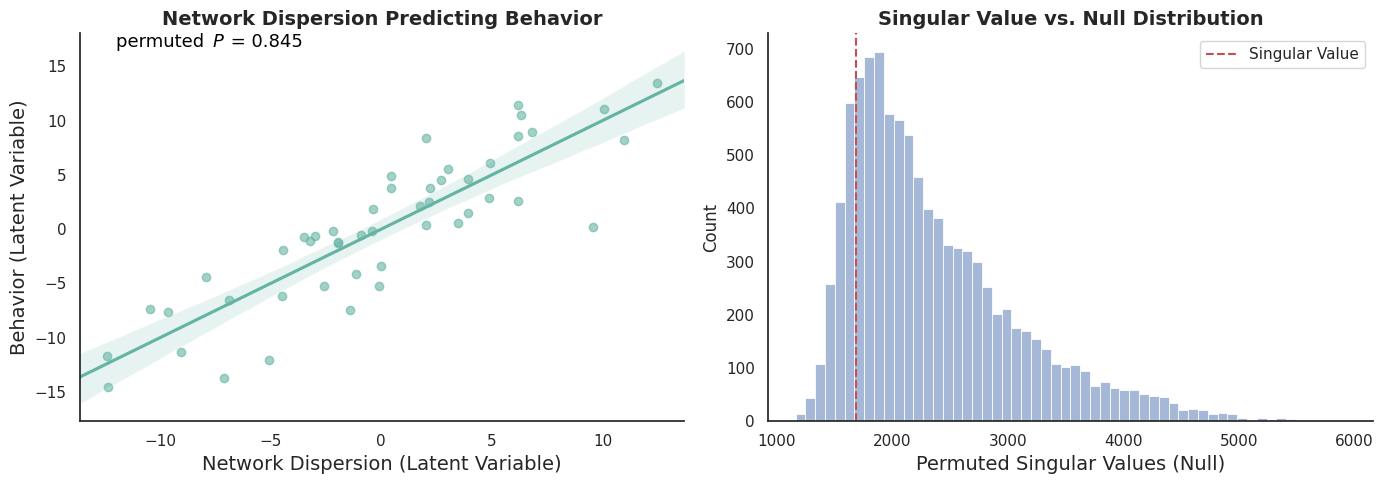

Starting Permutations


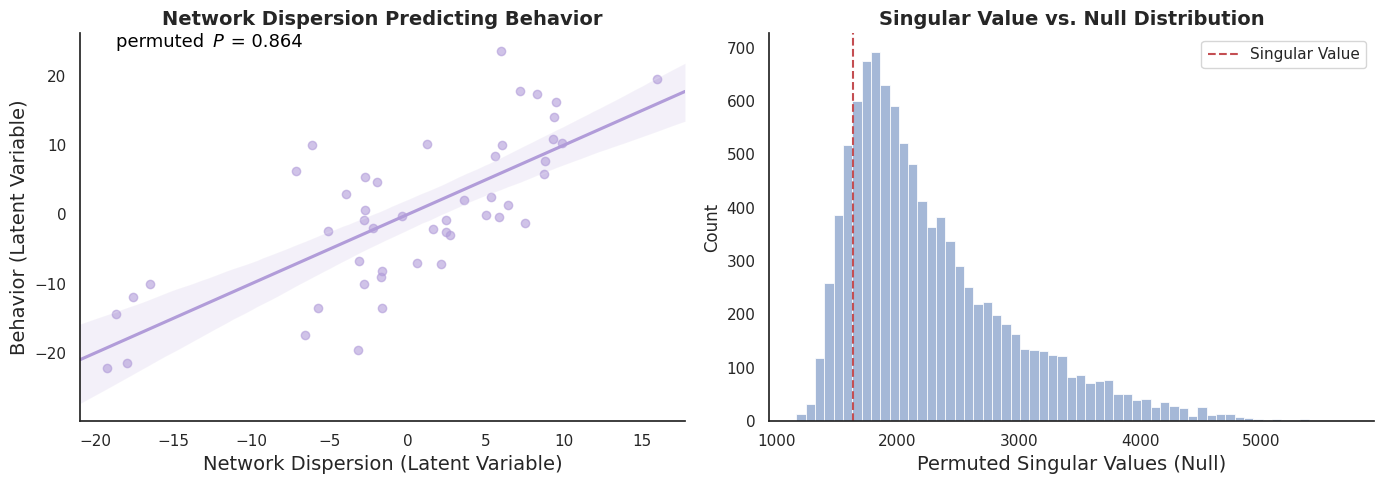

Starting Permutations


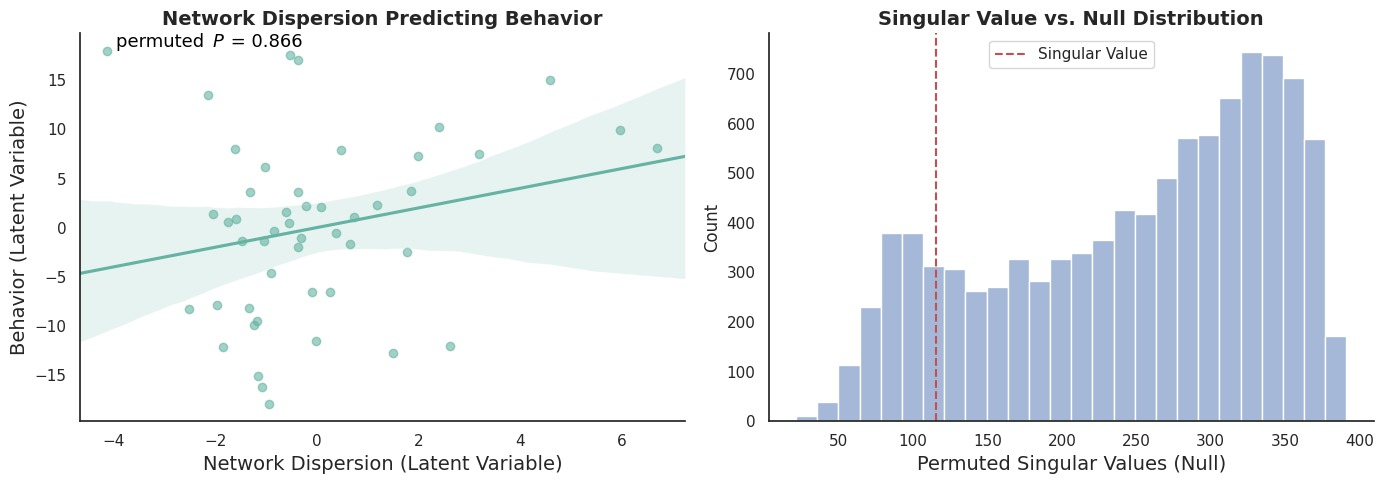

Starting Permutations


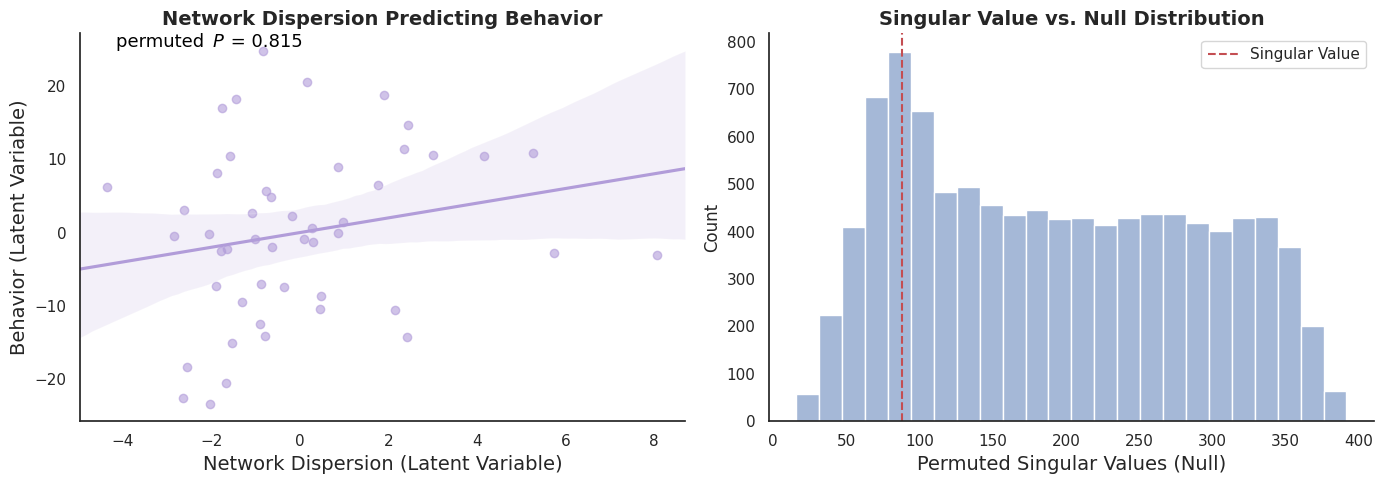

Starting Permutations


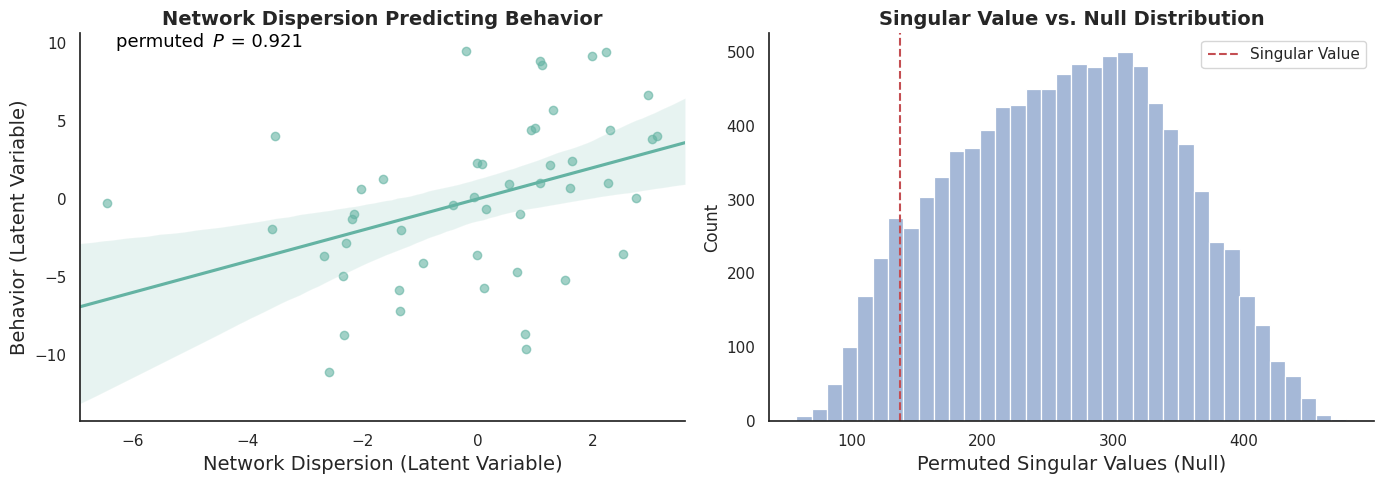

Starting Permutations


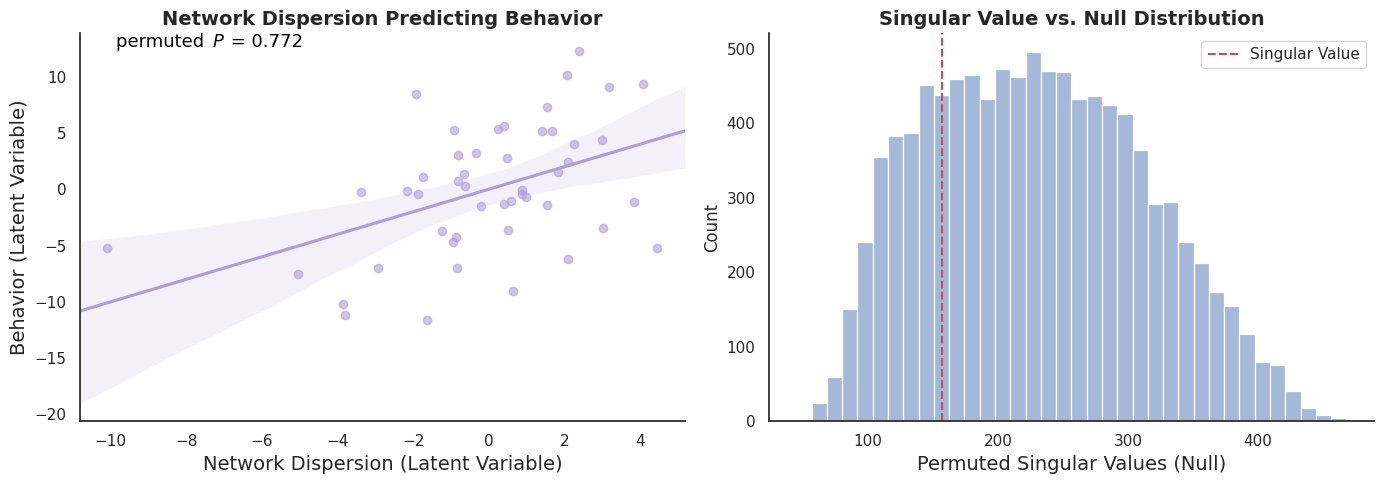

In [22]:
targets = [['RRS_total', 'PSWQ_total', 'WBSI_total'], ['z_ave']]
colors = ['#64b3a3', '#b19cd9']

networks = str_list = [str(i) for i in list(range(0,360))]
names = ['rrs_pws_wbsi_graddev', 'z_ave_graddev']
for i,j,k in zip(targets, colors, names):
    p_value, x_score, y_score, permuted_singular_values, singular_value = pls(subject_deviation_z, i, networks, j, k)

names = ['rrs_pws_wbsi_gradcor', 'z_ave_gradcor']
for i,j,k in zip(targets, colors, names):
    p_value, x_score, y_score, permuted_singular_values, singular_value = pls(subject_correlation_z, i, networks, j, k)
    
networks = ['vn', 'smn', 'fpcn', 'dmn']
names = ['rrs_pws_wbsi_netdev', 'z_ave_netdev']
for i,j,k in zip(targets, colors, names):
    p_value, x_score, y_score, permuted_singular_values, singular_value = pls(subject_network_deviation_z, i, networks, j, k)

names = ['rrs_pws_wbsi_netcor', 'z_ave_netcor']
for i,j,k in zip(targets, colors, names):
    p_value, x_score, y_score, permuted_singular_values, singular_value = pls(subject_network_correlation_z, i, networks, j, k)